# EDA with the different graph structures

In [1]:
import os
# set the directory to the root
os.chdir("/Users/jeandurand/Documents/Masters Thesis/causal_bayes_opt")
from utils.graph_utils.graph_6_nodes import Graph6Nodes
from utils.graph_utils.toy_graph import ToyGraph
from utils.sem_sampling import sample_model, sample_from_SEM_hat
from algorithms.CBO_algorithm import CBO
from algorithms.BO_algorithm import BO

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


INFO:root:Initializing the Toy Graph Structures
INFO:root:Setting up the structural equation model for the ToyGraph


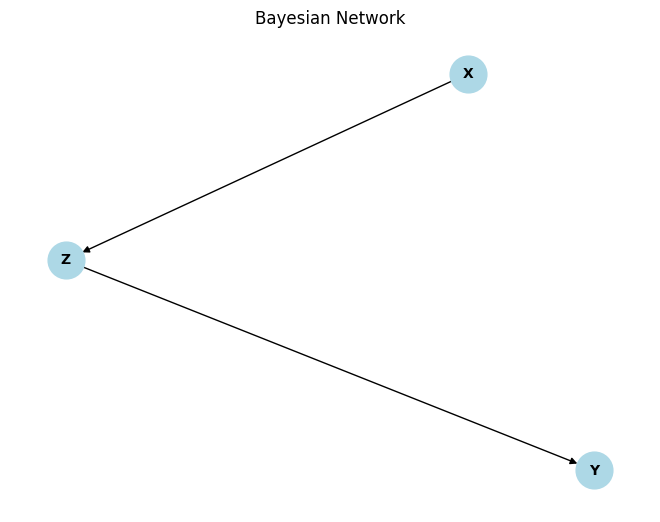

INFO:root:Fitting each sample to the graph based on the parents
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters



Name : GP regression
Objective : -81.35145927329138
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    0.7079708895108864  |      +ve      |        
  rbf.lengthscale          |    1.0014264047278838  |      +ve      |        
  Gaussian_noise.variance  |  0.009897426046623563  |      +ve      |        


In [2]:
graph = ToyGraph()
samples = sample_model(graph.SEM)
graph.show_graphical_model()
graph.fit_samples_to_graph(samples)
print(graph.functions['Y'])

INFO:root:Initializing the Toy Graph Structures
INFO:root:Setting up the structural equation model for the ToyGraph


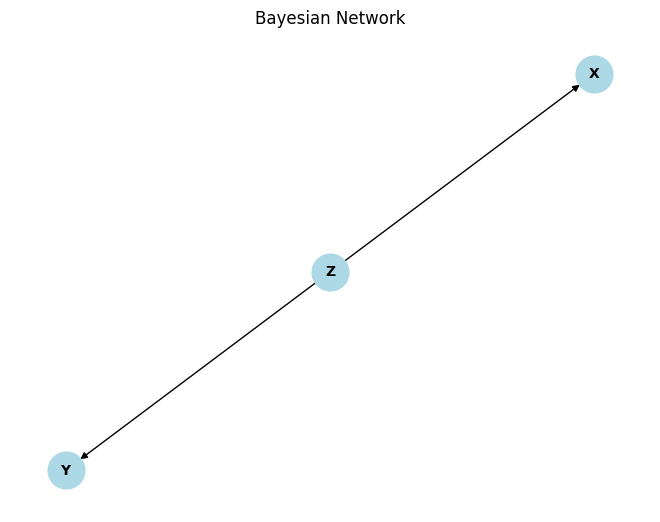

INFO:root:Fitting each sample to the graph based on the parents
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


OrderedDict([('X', <GPy.models.gp_regression.GPRegression object at 0x30d8f52a0>), ('Y', <GPy.models.gp_regression.GPRegression object at 0x30d91f280>)])


In [3]:
graph1 = ToyGraph()
graph1.mispecify_graph([("Z", "X"), ("Z", "Y")])
graph1.show_graphical_model()
graph1.fit_samples_to_graph(samples)
print(graph1.functions)

INFO:root:Initializing the Toy Graph Structures
INFO:root:Setting up the structural equation model for the ToyGraph


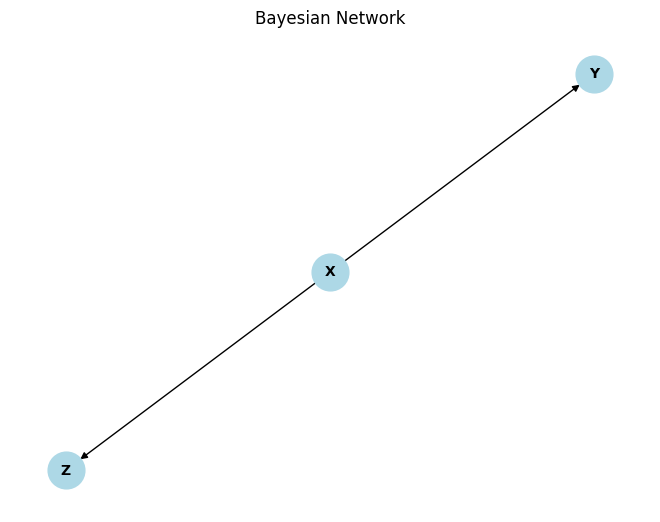

INFO:root:Fitting each sample to the graph based on the parents
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


OrderedDict([('Z', <GPy.models.gp_regression.GPRegression object at 0x30c796bc0>), ('Y', <GPy.models.gp_regression.GPRegression object at 0x30d96ff40>)])


In [4]:
graph2 = ToyGraph()
graph2.mispecify_graph([("X", "Z"), ("X", "Y")])
graph2.show_graphical_model()
graph2.fit_samples_to_graph(samples)
print(graph2.functions)

INFO:root:Initializing the Toy Graph Structures
INFO:root:Setting up the structural equation model for the ToyGraph


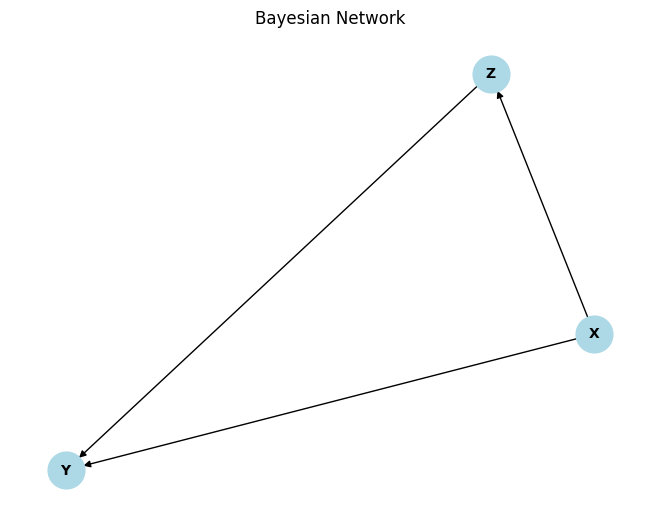

INFO:root:Fitting each sample to the graph based on the parents
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


OrderedDict([('Z', <GPy.models.gp_regression.GPRegression object at 0x30fef4370>), ('Y', <GPy.models.gp_regression.GPRegression object at 0x30d99f9a0>)])


In [5]:
graph3 = ToyGraph()
graph3.mispecify_graph([("X", "Z"), ("X", "Y"), ("Z", "Y")])
graph3.show_graphical_model()
graph3.fit_samples_to_graph(samples)
print(graph3.functions)

INFO:root:Initializing the Toy Graph Structures
INFO:root:Setting up the structural equation model for the ToyGraph


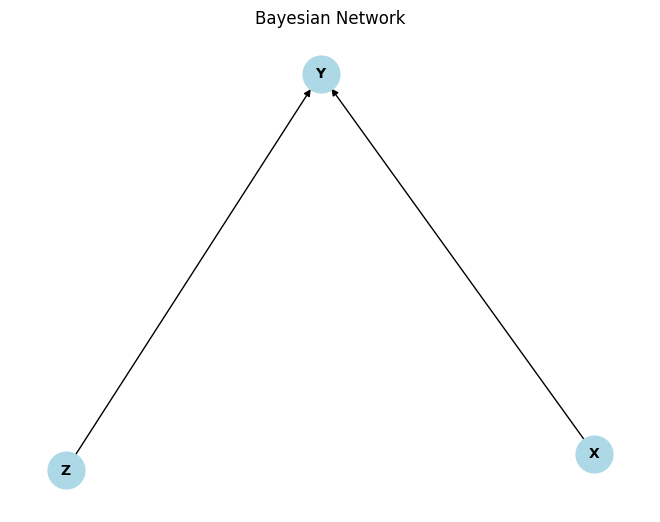

INFO:root:Fitting each sample to the graph based on the parents
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


OrderedDict([('Y', <GPy.models.gp_regression.GPRegression object at 0x30d96d3f0>)])


In [6]:
graph4 = ToyGraph()
graph4.mispecify_graph([("X", "Y"), ("Z", "Y")])
graph4.show_graphical_model()
graph4.fit_samples_to_graph(samples)
print(graph4.functions)

In [7]:
# print(graph.functions)
# sample_from_SEM_hat(graph.functions, graph)

In [8]:
from collections import OrderedDict
from networkx import MultiDiGraph
import numpy as np
from GPy.models import GPRegression
from typing import Callable

def select_sample(sample, input_variables):
    if isinstance(input_variables, str):
        return sample[input_variables].reshape(-1, 1)
    else:
        #  Takes either a tuple() or a list()
        samp = []
        input_variables = input_variables[0]
        for node in input_variables:
            if node == "Y":
                continue
            var = node
            samp.append(sample[var].reshape(-1, 1))
        return np.hstack(samp)
    

def build_sem_hat(G: MultiDiGraph, emission_fncs: OrderedDict[str, GPRegression]) -> classmethod:
    """
    This function is used to automatically create the SEM -function estimates for the edges in a given graph.

    Parameters
    ----------
    G : MultiDiGraph
        Causal graphical model
    emission_functions : dict
        A dictionary of fitted emission functions (roughly most horizontal edges in the DAG).
    transition_functions : dict
        A dictionary of fitted transition functions (roughly most vertical edges in the DAG)..

    Notes
    -----
    We have _NOT_ covered all network topologies with this function. Beware.

    Returns
    -------
    classmethod
        A SEM estimate found using observational data only; used in finding the optimal intervention set and values for CBO and DCBO.
    """



    class SEMHat:
        def __init__(self):
            self.G = G
            nodes = G.nodes()
            n_t = len(nodes) / G.T  # Number of nodes per time-slice
            assert n_t.is_integer()
            self.n_t = int(n_t)

        @staticmethod
        def _make_marginal(moment: int) -> Callable:
            #  Assigns the KDE for the marginal
            return lambda t, margin_id: emission_fncs[margin_id].predict()[moment]

        @staticmethod
        def _make_emit_fnc(moment: int) -> Callable:
            #  Within time-slice emission only
            return lambda emit_input_vars, sample: emission_fncs[emit_input_vars].predict(
                select_sample(sample, emit_input_vars)
            )[moment]

        # @staticmethod
        # def _make_trans_fnc(moment: int) -> Callable:
        #     #  Only transition between time-slices (only valid for first-order Markov assumption)
        #     return lambda t, transfer_input_vars, _, sample: transition_fncs[t][transfer_input_vars].predict(
        #         select_sample(sample, transfer_input_vars, t - 1)
        #     )[moment]

        # @staticmethod
        # def _make_emit_plus_trans_fnc(moment: int) -> Callable:
        #     #  Transition plus within-slice emission(s)
        #     return (
        #         lambda t, transfer_input_vars, emit_input_vars, sample: transition_fncs[t][transfer_input_vars].predict(
        #             select_sample(sample, transfer_input_vars, t - 1)
        #         )[moment]
        #         + emission_fncs[t][emit_input_vars].predict(select_sample(sample, emit_input_vars, t))[moment]
        #     )

        def static(self, moment: int) -> OrderedDict:
            assert moment in [0, 1], moment
            # SEM functions
            f = OrderedDict()
            # Assumes that the keys are causally ordered
            for v in list(self.G.nodes):
                if self.G.in_degree[v] == 0:
                    f[v] = self._make_marginal(moment)
                else:
                    f[v] = self._make_emit_fnc(moment)
            return f

        # def dynamic(self, moment: int) -> OrderedDict:
        #     assert moment in [0, 1], moment
        #     # SEM functions
        #     f = OrderedDict()
        #     # Variables are causally ordered
        #     for v in list(self.G.nodes)[self.n_t : 2 * self.n_t]:
        #         vv = v.split("_")[0]
        #         if self.G.in_degree[v] == 0:
        #             # Single source node
        #             f[vv] = self._make_marginal()
        #         elif all(int(vv.split("_")[1]) + 1 == int(v.split("_")[1]) for vv in G.predecessors(v)):
        #             # Depends only on incoming transition edge(s)
        #             f[vv] = self._make_trans_fnc(moment)
        #         elif all(vv.split("_")[1] == v.split("_")[1] for vv in G.predecessors(v)):
        #             # Depends only on incoming emission edge(s) from this time-slice
        #             f[vv] = self._make_emit_fnc(moment)
        #         else:
        #             # Depends incoming emission AND transition edges
        #             f[vv] = self._make_emit_plus_trans_fnc(moment)
        #     return f

    return SEMHat

class SEMHat:

    def __init__(self, G: MultiDiGraph, emission_fncs: OrderedDict[str, GPRegression]):
        self.G = G 
        self.emission_fncs = emission_fncs

    def _make_marginal(self, moment: int) -> Callable:
        #  Assigns the KDE for the marginal
        return lambda margin_id: self.emission_fncs[margin_id].predict()[moment]

    def _make_emit_fnc(self, moment: int) -> Callable:
        #  Within time-slice emission only
        return lambda emit_input_vars, sample: self.emission_fncs[emit_input_vars].predict(
            select_sample(sample, emit_input_vars)
        )[moment]
    
    def static(self, moment: int) -> OrderedDict:
        assert moment in [0, 1], moment
        # SEM functions
        f = OrderedDict()
        # Assumes that the keys are causally ordered
        for v in list(self.G.nodes):
            if self.G.in_degree[v] == 0:
                f[v] = self._make_marginal(moment)
            else:
                f[v] = self._make_emit_fnc(moment)
        return f


sem_hat = SEMHat(graph.G, graph.functions)
print(graph.functions)
sample_from_SEM_hat(graph.functions, graph)

OrderedDict([('Z', <GPy.models.gp_regression.GPRegression object at 0x103bbbc70>), ('Y', <GPy.models.gp_regression.GPRegression object at 0x30d38baf0>)])
(1, 1) [[0.76707978]]
(1, 1) [[0.27714645]]


OrderedDict([('X', array(0.76707978)),
             ('Z', array(0.27714645)),
             ('Y', array(-0.06826004))])